In [1]:
import numpy as np
import scipy
import scipy.stats

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

In [2]:
plt.rcParams.update({'font.size': 18})

## Task 1: Bayesian inference with MCMC

We will consider a simple case of Bayesian inference for the unknown mean parameter of a Normal distribution. A series of values $\boldsymbol{X}^{(n)} = X_1, X_2, \dots X_n$ is sampled **independently** from a Normal distribution and we know its variance in advance, but are unsure about the mean. We assign a prior distribution to this unknown mean and would like to infer its posterior. We are also interested in predicting future observations $X$, so we would like to obtain its posterior predictive distribution as well.
$$\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$X_i | \mu \sim \mathcal{N}(\mu, \sigma^2), \; i=1 \dots n.$$

In [3]:
np.random.seed(31337)

true_mu = 3.0
true_std = 0.3
N = 20

prior_mu = 0.
prior_std = 1.

X = np.random.normal(true_mu, true_std, N)

### Task 1.1: implement analytical posterior (1 point)

$$p(\mu | \boldsymbol{X}^{(n)}) = \frac{p(\boldsymbol{X}^{(n)} | \mu) p(\mu)}{p(\boldsymbol{X}^{(n)})}, \label{eq1} \tag{1}$$
$$p(\boldsymbol{X}^{(n)}) = \int p(\boldsymbol{X}^{(n)}, \mu) d\mu$$
For our simple case it is actually possible to derive the exact posterior distibution of the mean analytically. Posterior distiribution of $\mu$ will also be Normal, but with different parameters that will depend on the observed sample and prior parameters. Refer to https://en.wikipedia.org/wiki/Conjugate_prior for the exact formulas and implement them in the following function:

In [4]:
def analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    sigma_p = 1 / (1 / (sigma_0**2) + samples.shape[0] / (sigma**2))
    
    mu_p = sigma_p * (mu_0 / (sigma_0**2) + samples.sum() / (sigma**2))     
    
    return scipy.stats.norm(mu_p, np.sqrt(sigma_p)).pdf(x)


Plot the resulting analytical posterior for the given observed sample, standard deviation of $X_i$ and prior parameters.

In [5]:
x = np.linspace(X.min(), X.max(), 1000)

In [6]:
pdf_post = analytical_posterior_pdf(x, X, true_std, prior_mu, prior_std)

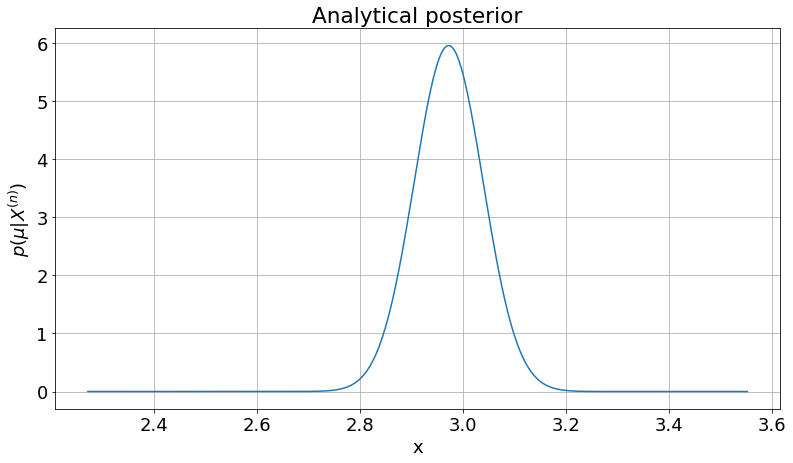

In [7]:
plt.figure(figsize=(13, 7))

plt.plot(x, pdf_post)

plt.title('Analytical posterior')
plt.xlabel('x')
plt.ylabel(r'$p(\mu|X^{(n)})$')
plt.grid()
plt.show()

### Task 1.2: Metropilis-Hastings algorithm (2 points)

In more complex models it is usually infeasible to derive the exact formula for the posterior density. In the equation (1), the numerator contains easy to evaluate terms: prior and likelihood, while the denominator is rather hard to find. This means that we know our posterior only up to a constant multiplicative term. We will have to resort to approximations. Previously in the course we have studied methods to estimate the unknown density from samples. If we could sample from this unknown posterior, we might be able to approximate it using a histogram or a kernel method.

This is precisely the goal of MCMC methods. We will construct a Markov chain that will eventually produce samples from our distribution of interest - the posterior.


Markov chain is a sequence of random variables $Y_1, Y_2, \dots$ with the following property:
$$p(Y_k | Y_{k-1}, Y_{k-2}, \dots, Y_2, Y_1) = p(Y_k | Y_{k-1}),$$
wich means that subsequent values ($Y_k$) do not depend on the whole history of the sequence if the previous value ($Y_{k-1}$) is given.

We want to start with our chain from the prior distribution $Y_1 \sim p(\mu)$ and eventually converge to the posterior $Y_k \sim p(\mu | \boldsymbol{X}^{(n)})$. In order to achieve this, we need to define the transition probabilities $p(Y_k | Y_{k-1})$ in a special way. Intuitevely, it will depend on the prior and posterior in some way and there may be different possibilities.

We will describe one way to do it, namely Metropilis-Hastings algorithm with a random walk proposal. It was introduced in lecture 10, slides 19-22. We will use it to draw a sequence of samples from a special markov chain that satisfies our requirements.

Let $T$ be the number of steps we decided to take from the chan. For our example model and using our notation the algorithm outilines as follows:

1. Start by sampling $Y_1$ from the prior $p(\mu)$
2. Repeat for each $k$ from 1 to T:
3. Construct the next sample $Y_{k+1}$ given the previous sampled value $Y_k$:
4. $Y_{k+1} = Y_{k} + Z_{k+1}$, where $Z_{k+1} \sim \mathcal{N}(0, \sigma_{step}^2)$ (we take a sample)
5. We need to decide whether to make the transition $Y_k \rightarrow Y_{k+1}$ (accept or reject our *proposed* new value $Y_{k+1}$):
6. Accept the new sample with probability $\min \left\{1, \frac{p(\boldsymbol{X}^{(n)} | \mu = Y_{k+1}) p(\mu = Y_{k+1})}{p(\boldsymbol{X}^{(n)} | \mu = Y_{k}) p(\mu = Y_{k})}\right\}$, otherwise let $Y_{k+1} = Y_k$

Notice that our acceptance probability equals the ratio of the **posterior** probabilities: $\frac{p(\mu=Y_{k+1} | \boldsymbol{X}^{(n)})}{p(\mu=Y_k | \boldsymbol{X}^{(n)})}$, since the denominator in formula (1) does not depend on $\mu$. This allows us to skip the hard part of taking the integral. 

Your task is to implement these steps, including the calculation of the acceptance probability, and run the chain. Numpy array `Y` should contain one MCMC trajectory that you have obtained as the result.

*You may need to tune the $\sigma_{step}$ parameter.

In [8]:
def acceptance_prob(y_new, y_old, samples, sigma, mu_0, sigma_0):
    """
    Calculate acceptance probability in Metropilis-Hastings step for the Normal model with known variance
    :param y_new: proposed value (corresponds to Y_{k+1})
    :param y_old: previous value (corresponds to Y_k)
    :param samples: observed data (X^(n))
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p, acceptance probability
    """
    
    new_post = analytical_posterior_pdf(y_new, samples, sigma, mu_0, sigma_0)
    old_post = analytical_posterior_pdf(y_old, samples, sigma, mu_0, sigma_0)
    
    r = new_post / old_post
    
    p = min(1, r)
    return p

In [9]:
T = 2000

sigma_step = 0.35

Y = np.empty(T)
sliding_avg = np.empty(T)

Y[0] = np.random.normal(prior_mu, prior_std)

num_accepted = 0
for i in tqdm(range(1, T)):
    Z = np.random.normal(0, sigma_step)
    Y_next = Y[i-1] + Z
    
    if np.random.rand() < acceptance_prob(Y_next, Y[i-1], X, true_std, prior_mu, prior_std):
        Y[i] = Y_next
        num_accepted += 1
    else:
        Y[i] = Y[i-1]
        
    sliding_avg[i] = num_accepted / (i + 1)

100%|██████████| 1999/1999 [00:01<00:00, 1625.32it/s]


### Task 1.3: Visualize the results (1 point)
We have obtained a single trajectory of our Markov chain. The starting portion the obtained values may be different from the samples of the actual posterior. After the so-called 'burn-in' or 'warmup' phase the distribution should become stationary and converge to the true posterior. Time spent before this convergence occurs is usually called *mixing time*, and it is hard to estimate in practical situations.

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

3. When do you think the 'mixing' occured? (Approximately)

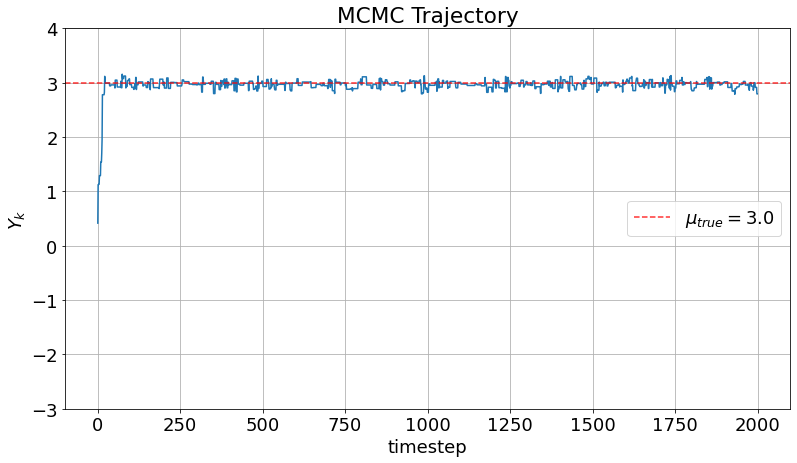

In [10]:
plt.figure(figsize=(13, 7))

plt.plot(Y)

plt.axhline(true_mu, c='r', linestyle='--', alpha=0.8, label=r'$\mu_{true}=$'f'{true_mu}')

plt.title('MCMC Trajectory')
plt.xlabel('timestеp')
plt.ylabel(r'$Y_k$')
plt.ylim(-3, 4)

plt.legend(loc='right')
plt.grid()
plt.show()

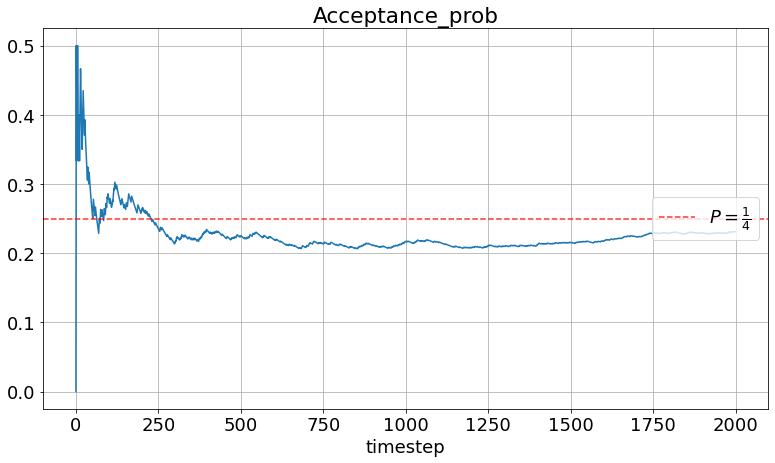

In [11]:
plt.figure(figsize=(13, 7))

plt.plot(sliding_avg)

plt.axhline(0.25, c='r', linestyle='--', alpha=0.8, label=r'$P=\frac{1}{4}$')

plt.title('Acceptance_prob')
plt.xlabel('timestеp')

plt.legend(loc='right')
plt.grid()
plt.show()

According to this [paper](https://projecteuclid.org/journals/annals-of-applied-probability/volume-7/issue-1/Weak-convergence-and-optimal-scaling-of-random-walk-Metropolis-algorithms/10.1214/aoap/1034625254.full), the fastest convergence speed  and consequently lowest $\textit{mixing time}$ could be achieved, when acceptance probability roughly converges to $\frac{1}{4}$.

### Task 1.4: Approximate posterior (1 points)

Now we have determined the part of our trajectory that converged to our target distribution (you can use your guess from the previous task or just designate first half the trajectory for mixing). We will work with the remaing part to approximate the posterior.

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run
2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample from the chain and display the corresponding distribution estimate on the same plot. Is it different?
3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate(s)?

In [12]:
from sklearn.neighbors import KernelDensity

In [13]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = int((sample_max - sample_min) / h)
    summ = 0
    deltas = [[sample_min + (i - 1) * h, sample_min + i * h] for i in range(1, bins+1)]
    for l, r in deltas:
        nu = np.sum([1 if l <= v <= r else 0 for v in sample])
        summ += (nu / n)**2
    
    return 2 / ((n - 1) * h) - (n + 1) / ((n - 1) * h) * summ

In [14]:
mid_id = int(Y.shape[0] / 2)
hist_samples = Y[mid_id:]

In [15]:
filtered_samples = [x for i, x in enumerate(hist_samples) if i % 5 == 0]

In [16]:
h_list = np.logspace(-2, 1, 100)

In [17]:
cv_hist = [cross_validation_histogram(hist_samples, hi) for hi in h_list]
f_cv_hist = [cross_validation_histogram(filtered_samples, hi) for hi in h_list]

In [18]:
h_cv = h_list[np.argmin(cv_hist)]
h_cv_f = h_list[np.argmin(f_cv_hist)]

In [19]:
def cross_validation_kernel(sample, h, K, K_conv):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    
    summ = 0
    for i in tqdm(range(sample.shape[0])):
        for j in range(sample.shape[0]):
            arg = (sample[i] - sample[j]) / h
            summ += K_conv(arg) - 2 * K(arg)
    
    return 1 / (h * n**2) * summ + 2 * K(0) / (n * h)

In [20]:
def gaussian_kernel(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

def gaussian_kernel_conv(x):
    return 1 / (2 * np.pi) * np.exp(-x**2 / 4)

In [21]:
h_list = np.logspace(-1, 1, 10)
cv_hist = [cross_validation_kernel(hist_samples, hi, gaussian_kernel, gaussian_kernel_conv) for hi in h_list]

100%|██████████| 1000/1000 [00:02<00:00, 412.96it/s]


In [22]:
h_kernel_cv = h_list[np.argmin(cv_hist)]

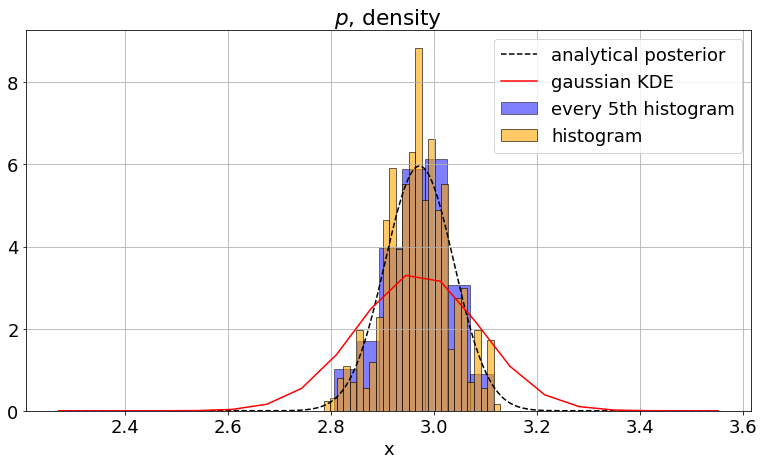

In [23]:
plt.figure(figsize=(13, 7))

sample_min, sample_max = np.min(filtered_samples), np.max(filtered_samples)
bins = int((sample_max - sample_min) / h_cv_f)

plt.hist(filtered_samples, bins=bins, edgecolor='black', alpha=0.5, label='every 5th histogram', density=True, color='blue')

sample_min, sample_max = np.min(hist_samples), np.max(hist_samples)
bins = int((sample_max - sample_min) / h_cv)

plt.hist(hist_samples, bins=bins, edgecolor='black', alpha=0.6, label='histogram', density=True, color='orange')

plt.plot(x, pdf_post, 'k--', label='analytical posterior')

grid = np.linspace(X.min(), X.max(), X.shape[0])
density = KernelDensity(kernel="gaussian", bandwidth=h_kernel_cv).fit(hist_samples[:, None])
plt.plot(grid, np.exp(density.score_samples(grid[:, None])), label='gaussian KDE', color='red')

plt.title(r'$p$, density')
plt.xlabel('x')

plt.legend()
plt.grid()
plt.show()

### Task 1.5: Posterior predictive distribution (1 bonus point)

Now that we have obtained the estimate of the posterior, we can turn to a more practical task: predicting new values $X_{n+1}$. To do it in a Bayesian fashion, we employ posterior predictive distribution:
$$p(X_{n+1} | \boldsymbol{X}^{(n)}) = \int p(X_{n+1}, \mu | \boldsymbol{X}^{(n)}) d \mu = \int p(X_{n+1} | \mu, \boldsymbol{X}^{(n)}) p(\mu | \boldsymbol{X}^{(n)})d \mu = \int p(X_{n+1} | \mu) p(\mu | \boldsymbol{X}^{(n)})d \mu$$

Similar to part 1, for our simple model this distribution can also be derived analyticaly and is described on the same Wiki page.

1. Implement analytical posterior predictive distribution for our model and plot it
2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add it to the plot. Is it close to the analytical result?

# Task 2. Substitution Cipher and Markov Chain Monte Carlo (MCMC). (5 points)

In this task we will decrypt data that was scrambled using a Substitution Cipher. We assume that encryption key is unknown and we want to decrypt the data and read the code using recovered decryption key. [Introduction from here](http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf) gives reference to the original task.

In [24]:
import string

As verification we will take a piece from "Alice's adventures in Wonderland". We scramble data with a random encryption key, which we forgot after encrypting, and we would like to decrypt this encrypted text using MCMC Chains.

In [25]:
plain_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before see a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again.
The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well.
"""

We will use 26 letters of English alphabet.

In [26]:
characters = string.ascii_lowercase
characters_dict = {char : c for c, char in enumerate(characters, start=1)}
m = len(characters) + 1

## Generate random encryption key.

Here are functions that will be used to encrypt/decrypt text.

In [27]:
def encode_text(text_to_encode, characters_dict):
    """This function turns a text string into an integer sequence using given dictionary."""
    characters_set = set(characters_dict.keys())
    return np.r_[[characters_dict[char] if char in characters_set else 0 for char in text_to_encode.strip().lower()]]

def decode_text(text_to_decode, characters):
    """This function turns an integer sequence into a text string using given list of characters."""
    characters_array = np.array([" "] + list(characters))
    return "".join(characters_array[text_to_decode])

def apply_cipher(text_as_int_array, cipher):
    "This function applies substitution cipher to an integer sequence."
    return cipher[text_as_int_array]

Generate encryption and decryption keys. They are just permutations of the alphabet.

In [28]:
np.random.seed(1234)

encryption_indices = np.random.permutation(np.arange(m-1))
decryption_indices = np.argsort(encryption_indices)

characters_array = np.array(list(characters))
encryption_key = "".join(characters_array[encryption_indices])
decryption_key = "".join(characters_array[decryption_indices])

Check encoding/decoding functions and encryption/decryption keys.

In [29]:
encryption_key_encoded = np.r_[0, encode_text(encryption_key, characters_dict)]
decryption_key_encoded = np.r_[0, encode_text(decryption_key, characters_dict)]

text = "The quick brown fox jumps over the lazy dog"

encoded_text = encode_text(text, characters_dict)
cipher_text = apply_cipher(encoded_text, encryption_key_encoded)
encoded_text = apply_cipher(cipher_text, decryption_key_encoded)
decoded_text = decode_text(encoded_text, characters_dict)
decoded_text

'the quick brown fox jumps over the lazy dog'

Encrypt cipher text.

In [30]:
plain_text_encoded = encode_text(plain_text, characters_dict)
cipher_text = apply_cipher(plain_text_encoded, encryption_key_encoded)

## Collect frequences 

Collect frequences of two character combinations (bigrams) over large text corpus and from encrypted text. We will store them in a matrix and interpret it as a transition matrix: from the first character to the second.

In [31]:
def collect_transition_frequences(data, transition_matrix):
    """For a given integer sequence, which corresponds to some char sequence, 
       return transitions for adjacent values."""
    transitions = data.repeat(2)[1:-1].reshape(-1, 2)
    for i, j in transitions:
        transition_matrix[i, j] += 1
    
    return transition_matrix

def collect_empirical_frequences(filename, characters_dict, m):
    """Collect frequences over large text corpus, return transition matrix."""
    transition_matrix = np.zeros((m, m))
    with open(filename) as f:
        for line in f:
            line_encoded = encode_text(line, characters_dict)
            if line_encoded.size > 1:
                transition_matrix = collect_transition_frequences(line_encoded, transition_matrix)
                
    return transition_matrix

def collect_observed_frequences(cipher_text, characters_dict, m):
    """Collect frequences over encrypted text, return nonzero indices of 
       transition matrix for both dimentions and values for those indices.
       `values = transition_matrix[indices_1, indices_2]`"""
    transition_matrix = np.zeros((m, m))
    transition_matrix = collect_transition_frequences(cipher_text, transition_matrix)
    
    return transition_matrix

Collect frequences.

In [32]:
empirical_frequences = collect_empirical_frequences('war_and_peace.txt', characters_dict, m)
observed_frequences = collect_observed_frequences(cipher_text, characters_dict, m)

## General algorithm

Our Chain will include states that are permutations of the substitution cipher. Algorithm has following steps:

1. Start by picking up a random current state. 
2. Create a proposal for a new state by swapping two or more random letters in the current state.
3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed state $Score_{new}$.
4. If the score of the proposed state is more than current state, Move to Proposed State.
5. Else flip a coin which has a probability of Heads $\frac{Score_{new}}{Score_{old}}$  . If it comes heads move to proposed State.
6. Repeat from Step 2.

We want ot reach a steady state where the chain has the stationary distribution of the needed states. This state of chain could be used as a solution.

Let's start with implementing steps 2 and 3.

## Step 2: Prepare sampling function (2 points).



To generate a new proposed cipher we randomly select several positions and swap values at those positions. It corresponds to change in seveal mappings of encrypted characters in decrypted ones. Example with 2 swaps.

was|now
-|-
A -> B | A -> B
B -> C | B -> C
C -> D | C -> A
D -> A | D -> D

In [33]:
def generate_cipher(cipher, m, size=2):
    """Swap two or more random positions in cipher.
        
        cipher, np.array - current mapping from value(int) in encrypted text (index of array cell) into value(int) in decrypted text(value of array cell).
        m, int - capacity of used alphabet,
        size, int - number of positions to change.
    """
    
    new_cipher = cipher.copy()
    
    indexes = np.sort(np.random.choice(np.arange(m), size, False))
    perms = indexes.copy()
    
    np.random.shuffle(perms)
    new_cipher[indexes] = new_cipher[perms]
    
    return new_cipher

## Step 3: Prepare scoring function (2 points).

We want to use a scoring function for each state(Decryption key) which assigns a positive score to each decryption key. This score intuitively should be larger if the encrypted text looks more like actual english, when decrypted using this decryption key. We will check a large text and calculate frequences: how many times one character comes after another in a large text like "War and Peace".

For each pair of characters $\beta_1$ and $\beta_2$ (e.g. $\beta_1$ = A and $\beta_2$ = B), we let $R(\beta_1,\beta_2)$ record the number of times that specific pair(e.g. "AB") appears consecutively in the reference text.

Similarly, for a considered decryption key $x$, we let $F_x(\beta_1,\beta_2)$ record the number of times that
pair appears when the cipher text is decrypted using the decryption key $x$.

We then Score a particular decryption key $x$ using:

$$Score(x) = \prod R(\beta_1,\beta_2)^{F_x(\beta_1,\beta_2)}$$
    
To make life easier with calculations we will calculate $log(Score(x))$

Now, you need to implement scoring function. As input it takes 
- `cipher`: mapping between encrypted characters and decrypted characters,
- `observed_frequences`: transition matrix for cipher text, matrix representation of $F_x(\beta_1,\beta_2)$,
- `empirical_frequences`: transition matrix for large text, matrix representation of $R(\beta_1,\beta_2)$.

Scoring function returns $log(Score(x))$. You need correctly process zero values in transition matrices while calculating the score.

In [34]:
def score_cipher(cipher, observed_frequencies, empirical_frequencies):
    a = empirical_frequencies.copy()
    a = a[cipher][:, cipher]
    
    mask = a != 0.
    score = np.sum(np.log(a[mask]) * observed_frequencies[mask])
    
    return score

## Decryption

Now we a ready to decrypt cipher text.

In [35]:
def decrypting(observed_frequences, empirical_frequences, n_iters, m, step_size, seed, print_it=1000):
    """This function finds most suited decrypting cipher(1D np.array).
        observed_frequences, 2D np.array - transition matrix with frequences for cipher text,
        empirical_frequences, 2D np.array - transition matrix with frequences for large text,
        n_iters, int - number of MCMC iterations,
        step_size, int - number of changes in cipher per one iteration,
        seed, int - seed for random generator,
        print_it, int - print decrypted text every `print_it` iterations.
    """

    np.random.seed(seed)

    # 1. Start by picking up a random current state. 
    cipher_old = np.arange(m)
    score_cipher_old = score_cipher(cipher_old, observed_frequences, empirical_frequences)
    best_state, score = cipher_old, score_cipher_old

    scores = []
    
    best_accuracy = 0
    final_it = None
    
    for i in tqdm(range(1, n_iters+1)):

        # 2. Create a proposal for a new state by swapping two or more random letters in the current state.
        cipher_new = generate_cipher(cipher_old, m, size=step_size)

        # 3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed State $Score_{new}$.
        score_cipher_new = score_cipher(cipher_new, observed_frequences, empirical_frequences)
        acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))

        # 4. If the score of the proposed state is more than current state, Move to Proposed State.
        # 5. Else flip a coin which has a probability of Heads $Score_{new}/Score_{old}$. If it comes heads move to proposed State.
        if score_cipher_old > score:
            best_state, score = cipher_old, score_cipher_old
        if acceptance_probability > np.random.uniform(0,1):
            cipher_old, score_cipher_old = cipher_new, score_cipher_new
        if i % print_it == 0:
            print(f"iter {i}: {decode_text(apply_cipher(cipher_text[0:99], cipher_old), characters)}")
            
        a = ''.join(characters_array[cipher_old[1:]-1])
        b = decryption_key 

        accuracy = sum([1 if x == y else 0 for x, y in zip(a, b)]) / len(a)
        
        if accuracy >= best_accuracy:
            if accuracy > best_accuracy:
                final_it = i
            scores.append(accuracy)
            
        best_accuracy = max(best_accuracy, accuracy)

    return best_state, scores, final_it

In [36]:
decrypt_cipher, _, _ = decrypting(observed_frequences, empirical_frequences, 10000, m, 4, 345, 1000)

print(
    f"\nDecoded Text: {decode_text(apply_cipher(cipher_text, decrypt_cipher), characters)}\n\n"
    f"MCMC KEY  : {''.join(characters_array[decrypt_cipher[1:]-1])}\n"
    f"ACTUAl KEY: {decryption_key}"
)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-35-3d5dd92d1269>:30: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))
 64%|██████▍   | 6432/10000 [00:00<00:00, 32205.17it/s]

iter 1000: isace wit pekannank ro ker xedl radef om tarrank pl hed tatred on rhe piny  inf om hixank norhank r
iter 2000: agice wat peyinniny so yes berl sired om tissiny pl her titser on she pank  and om habiny noshiny s
iter 3000: amice was beginning to get pery tired of sitting by her sister on the bank  and of haping nothing t
iter 4000: alice was peginning to get bery tired of sitting py her sister on the pank  and of habing nothing t
iter 5000: alice was peginning to get bery tired of sitting py her sister on the pank  and of habing nothing t
iter 6000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 7000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t


100%|██████████| 10000/10000 [00:00<00:00, 32174.41it/s]

iter 8000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 10000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t

Decoded Text: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing to do  once or twice she had peeped into the book her sister was reading  but it had no pictures or conversations in it   and what is the use of a book   thought alice  without pictures or conversation   so she was considering in her own mind  as well as she could  for the hot day made her feel very sleepy and stupid   whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies  when suddenly a white rabbit with pink eyes ran close by her  there was nothing so very remarkable in that  nor did alice

## Tuning parameters (1 point).

For step sizes in range `[2, ..., 7]`(number of pertrubations in newly generated cipher) find number of iterations, with `..00` precision(`print_it=100`), which is necessary to make cipher text looks more like english one. Plot obtained results.

In [37]:
plot_info = []

In [38]:
for step in range(2, 8):
    _, scores, it_num = decrypting(observed_frequences, empirical_frequences, 10000, m, step, 69, 100)

    plot_info.append((step, scores, it_num))

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-35-3d5dd92d1269>:30: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))
 31%|███       | 3075/10000 [00:00<00:00, 30747.83it/s]

iter 100: hcake nhr tebaiiaib lw bel pedq ladem wo rallaib tq sed rarled wi lse thiz  him wo shpaib iwlsaib l
iter 200: icake nir tebahhahb lw bel pedv ladem wo rallahb tv sed rarled wh lse tihx  ihm wo sipahb hwlsahb l
iter 300: icape nil debarrarb to bet kevh tavem ow lattarb dh sev laltev or tse dirx  irm ow sikarb rotsarb t
iter 400: icape nil vebarrarb so bes kedh sadem ow lassarb vh ted lalsed or ste virx  irm ow tikarb rostarb s
iter 500: inape cil febarrarb so bes vedy sadem ow lassarb fy ted lalsed or ste firx  irm ow tivarb rostarb s
iter 600: inape cil befarrarf so fes vemy samed ow lassarf by tem lalsem or ste birg  ird ow tivarf rostarf s
iter 700: inape cil befarrarf so fes vemy samed ow lassarf by tem lalsem or ste birg  ird ow tivarf rostarf s
iter 800: inape cil befarrarf so fes vemy samed ow lassarf by tem lalsem or ste birg  ird ow tivarf rostarf s
iter 900: inape cil begarrarg so ges vemy samed ow lassarg by tem lalsem or ste birf  ird ow tivarg rostarg s
iter 1000:

 62%|██████▏   | 6150/10000 [00:00<00:00, 30556.24it/s]

iter 4100: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4200: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4300: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4400: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4500: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4600: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4700: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4800: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4900: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

100%|██████████| 10000/10000 [00:00<00:00, 30832.04it/s]


iter 6300: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6400: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6500: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6600: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6700: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6800: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 6900: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 7000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 7100: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

  0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: osewa ior qagenneng py gap valm pelad yf reppeng qm tal rerpal yn pta qonh  ond yf toveng nypteng p
iter 200: iseho air wopennenp ly pol vomf lemod yc rellenp wf tom rerlom yn lto wing  ind yc tivenp nyltenp l
iter 300: aseho bar wokennenk tu kot vomf temod ug rettenk wf lom rertom un tlo wanc  and ug lavenk nutlenk t
iter 400: asuyo bar woiunnuni te iot vomf tumod eg ruttuni wf lom rurtom en tlo wanc  and eg lavuni netluni t
iter 500: alupo bar woiunnuni se ios vomf sumod ey russuni wf tom rursom en sto wanc  and ey tavuni nestuni s
iter 600: alupo bar woiunnuni se ios vomf sumod ey russuni wf tom rursom en sto wanc  and ey tavuni nestuni s
iter 700: alipo bar couinninu se uos vomf simod ey rissinu cf tom rirsom en sto cang  and ey tavinu nestinu s
iter 800: alipo bar cofinninf se fos vomu simod ey rissinf cu tom rirsom en sto cang  and ey tavinf nestinf s
iter 900: alico war pofinninf se fos vomy simod eu rissinf py tom rirsom en sto pang  and eu tavinf nestinf s
iter 1000:

 61%|██████    | 6121/10000 [00:00<00:00, 30667.35it/s]

iter 2500: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 2600: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 2700: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 2800: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 2900: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 3000: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 3100: alice was peginning to get mery tired of sitting py her sister on the pank  and of haming nothing t
iter 3200: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 3300: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

100%|██████████| 10000/10000 [00:00<00:00, 30527.85it/s]


iter 8700: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 8800: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 8900: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9100: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9200: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9300: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9400: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
iter 9500: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing t
i

  0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: atuyo sar pomuiiuim ne mon cobz nubof ew runnuim pz gob rurnob ei ngo pail  aif ew gacuim ienguim n
iter 200: atuyo wam pohurrurh ne hon docv nucof eg munnurh pv soc mumnoc er nso parl  arf eg sadurh rensurh n
iter 300: atuhe wam peyurrury no yen defv nufel og munnury pv sef mumnef or nse park  arl og sadury ronsury n
iter 400: atude wam beyurrury no yen pefv nufel og munnury bv sef mumnef or nse bark  arl og sapury ronsury n
iter 500: atude wam ceyurrury no yen pefg nufel ov munnury cg sef mumnef or nse cark  arl ov sapury ronsury n
iter 600: ayude was cemurrurm no men pefg nufel ov sunnurm cg tef susnef or nte cark  arl ov tapurm ronturm n
iter 700: adipe was cemirrirm no men befy nifel ov sinnirm cy tef sisnef or nte cark  arl ov tabirm rontirm n
iter 800: adive was cepirrirp no pen bemy nimel of sinnirp cy tem sisnem or nte cark  arl of tabirp rontirp n
iter 900: alive was cehirrirh no hen bemy nimed of sinnirh cy tem sisnem or nte cark  ard of tabirh rontirh n
iter 1000:

 30%|██▉       | 2991/10000 [00:00<00:00, 29903.40it/s]

iter 2600: alice was mepinninp to pet very tired of sittinp my her sister on the mank  and of havinp nothinp t
iter 2700: alice was mepinninp to pet very tired of sittinp my her sister on the mank  and of havinp nothinp t
iter 2800: alice was mepinninp to pet very tired of sittinp my her sister on the mank  and of havinp nothinp t
iter 2900: alice was pefinninf to fet very tired om sittinf py her sister on the pank  and om havinf nothinf t
iter 3000: alice was pefinninf to fet very tired om sittinf py her sister on the pank  and om havinf nothinf t
iter 3100: alice was pefinninf to fet very tired om sittinf py her sister on the pank  and om havinf nothinf t
iter 3200: alice was peginning to get very tired om sitting py her sister on the pank  and om having nothing t
iter 3300: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 3400: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

 60%|██████    | 6025/10000 [00:00<00:00, 30153.96it/s]

iter 4700: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4800: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 4900: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5100: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5200: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5300: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5400: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 5500: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

100%|██████████| 10000/10000 [00:00<00:00, 30141.19it/s]


iter 8700: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 8800: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 8900: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9000: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9100: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9200: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9300: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9400: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
iter 9500: alice was peginning to get very tired of sitting py her sister on the pank  and of having nothing t
i

  0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: utaeo fuk iogarrarg nl gon pomh namoy lb kannarg ih com kaknom lr nco iurw  ury lb cuparg rlncarg n
iter 200: itabo fiu gosannans rl sor codh radom lp uarrans gh yod uaurod ln ryo gink  inm lp yicans nlryans r
iter 300: itabo fiu gosannans rl sor codh radom lp uarrans gh yod uaurod ln ryo gink  inm lp yicans nlryans r
iter 400: isaco biu gofannanf rl for jodh radot lp uarranf gh yod uaurod ln ryo ginm  int lp yijanf nlryanf r
iter 500: isamo bic gofannanf rl for jodk radot lp carranf gk yod cacrod ln ryo ginu  int lp yijanf nlryanf r
iter 600: isabo mig cofannanf rl for jodk radot lp garranf ck yod gagrod ln ryo cinu  int lp yijanf nlryanf r
iter 700: isabo mig cofannanf rl for jodk radot lp garranf ck yod gagrod ln ryo cinu  int lp yijanf nlryanf r
iter 800: isabo uig coyannany rl yor jodk radof lp garrany ck tod gagrod ln rto cinm  inf lp tijany nlrtany r
iter 900: isebo hin coyeaaeay rl yor jodk redof lp nerreay ck tod nenrod la rto ciam  iaf lp tijeay alrteay r
iter 1000:

 29%|██▉       | 2934/10000 [00:00<00:00, 29334.15it/s]

iter 2200: imobe hin ceyolloly sa yes verf sored ag nossoly cf ter nonser al ste cilk  ild ag tivoly lastoly s
iter 2300: imope hin beyolloly sa yes verf sored ag nossoly bf ter nonser al ste bilk  ild ag tivoly lastoly s
iter 2400: imope hin beyolloly sa yes verf sored ag nossoly bf ter nonser al ste bilk  ild ag tivoly lastoly s
iter 2500: imope hin beyolloly sa yes verf sored ag nossoly bf ter nonser al ste bilk  ild ag tivoly lastoly s
iter 2600: omipe hon beyillily sa yes verf sired ag nissily bf ter ninser al ste bolk  old ag tovily lastily s
iter 2700: omipe hon beyillily sa yes verf sired ag nissily bf ter ninser al ste bolk  old ag tovily lastily s
iter 2800: omipe hon beyillily sa yes verf sired aw nissily bf ter ninser al ste bolk  old aw tovily lastily s
iter 2900: omipe hon beyillily sa yes verf sired aw nissily bf ter ninser al ste bolk  old aw tovily lastily s
iter 3000: omipe hon beyillily sa yes verf sired aw nissily bf ter ninser al ste bolk  old aw tovily lastily s
i

 59%|█████▊    | 5868/10000 [00:00<00:00, 29003.24it/s]

iter 4700: alime was beginning to get cery tired ov sitting by her sister on the bank  and ov hacing nothing t
iter 4800: alime was beginning to get cery tired ov sitting by her sister on the bank  and ov hacing nothing t
iter 4900: alime was beginning to get cery tired ov sitting by her sister on the bank  and ov hacing nothing t
iter 5000: alime was beginning to get cery tired ov sitting by her sister on the bank  and ov hacing nothing t
iter 5100: alime was beginning to get very tired oc sitting by her sister on the bank  and oc having nothing t
iter 5200: alime was beginning to get very tired oc sitting by her sister on the bank  and oc having nothing t
iter 5300: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 5400: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 5500: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
i

100%|██████████| 10000/10000 [00:00<00:00, 29213.21it/s]


iter 8100: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8200: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8300: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8400: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8500: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8600: alime was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8700: alife was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8800: alife was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
iter 8900: alife was beginning to get very tired op sitting by her sister on the bank  and op having nothing t
i

  0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: dyal okdnoj carrarcosboc sov tqosat iobponassarcojqoe tonans tobrose ojdrwoodriobpoedvarcorbsearcos
iter 200: fvau okfnoy caiiaicosroc sop tlosat morbonassaicoyloe tonans toriose oyfigoofimorboefpaicoirseaicos
iter 300: nvay okngom caiiaicosroc sop tlosat forbogassaicomloe togags toriose omniqooniforboenpaicoirseaicos
iter 400: nvay ownhom caiiaicosroc sop tlosat forbohassaicomloe tohahs toriose omnidooniforboenpaicoirseaicos
iter 500: nvay ownhom caiiaicosroc sop tlosat forbohassaicomloe tohahs toriose omnidooniforboenpaicoirseaicos
iter 600: nlay ownhom caiiaicosroc sod tvosat forbohassaicomvoe tohahs toriose omnipooniforboendaicoirseaicos
iter 700: noaye wnh cemauuaum sl mes detv sateg lp hassaum cv iet hahset lu sie cnuf  nug lp indaum ulsiaum s
iter 800: noape wnh ceuaddadu sl ues betv sateg ly hassadu cv iet hahset ld sie cndf  ndg ly inbadu dlsiadu s
iter 900: noape wnr ceuaddadu sl ues betf sateg ly rassadu cf iet rarset ld sie cndh  ndg ly inbadu dlsiadu s
iter 1000:

 27%|██▋       | 2652/10000 [00:00<00:00, 26515.79it/s]

iter 2400: amico wat bogillilg se gos donp sinor ek tissilg bp hon titson el sho baly  alr ek hadilg leshilg s
iter 2500: amico wat bogillilg se gos donk sinor ev tissilg bk hon titson el sho baly  alr ev hadilg leshilg s
iter 2600: amico wat bogillilg se gos donk sinor ev tissilg bk hon titson el sho baly  alr ev hadilg leshilg s
iter 2700: avice was begimmimg to get denk tiner ol sittimg bk hen sisten om the bamy  amr ol hadimg mothimg t
iter 2800: avice was begimmimg to get denk tiner ol sittimg bk hen sisten om the bamy  amr ol hadimg mothimg t
iter 2900: avice mas begiddidg to get fenk tiner ol sittidg bk hen sisten od the bady  adr ol hafidg dothidg t
iter 3000: avice mas pegiddidg to get fenk tiner ol sittidg pk hen sisten od the pady  adr ol hafidg dothidg t
iter 3100: avice mas pegiddidg to get fenk tiner ol sittidg pk hen sisten od the pady  adr ol hafidg dothidg t
iter 3200: avice mas pegiddidg to get fenk tiner ol sittidg pk hen sisten od the pady  adr ol hafidg dothidg t
i

 56%|█████▌    | 5584/10000 [00:00<00:00, 28159.59it/s]

iter 3700: avice was pegirrirg to get yenk tined ol sittirg pk hen sisten or the parf  ard ol hayirg rothirg t
iter 3800: avice was pegirrirg to get yenk tined ol sittirg pk hen sisten or the parf  ard ol hayirg rothirg t
iter 3900: alice was pegirrirg to get yenk tined ob sittirg pk hen sisten or the parf  ard ob hayirg rothirg t
iter 4000: alice bas pegirrirg to get wenk tined of sittirg pk hen sisten or the pary  ard of hawirg rothirg t
iter 4100: alice bas pegirrirg to get wenk tined of sittirg pk hen sisten or the pary  ard of hawirg rothirg t
iter 4200: alice bas pegirrirg to get wenk tined of sittirg pk hen sisten or the pary  ard of hawirg rothirg t
iter 4300: alice bas pegirrirg to get wenk tined of sittirg pk hen sisten or the pary  ard of hawirg rothirg t
iter 4400: alice bas pegirrirg to get wenk tined of sittirg pk hen sisten or the pary  ard of hawirg rothirg t
iter 4500: alice bas pegirrirg to get wenk tined of sittirg pk hen sisten or the pary  ard of hawirg rothirg t
i

 85%|████████▍ | 8485/10000 [00:00<00:00, 28546.03it/s]

iter 8300: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 8400: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 8500: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 8600: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 8700: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 8800: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 8900: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 9000: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 9100: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
i

100%|██████████| 10000/10000 [00:00<00:00, 28362.83it/s]


iter 9600: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 9700: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 9800: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 9900: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t
iter 10000: alice was meginning to get bery tired of sitting my her sister on the mank  and of habing nothing t


  0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: ywiue hyf tesirrirs ao sea qedg aidec ob fiaairs tg ned fifaed or ane tyrp  yrc ob nyqirs roanirs a
iter 200: slice dsw hexiuuiux ao xea fent ainer oy wiaaiux ht men wiwaen ou ame hsup  sur oy msfiux uoamiux a
iter 300: smrce lsw hexruurux ao xea fent arned oy wraarux ht ien wrwaen ou aie hsup  sud oy isfrux uoairux a
iter 400: sbuce rst hexullulx ao xea fenm auned oy tuaaulx hm ien tutaen ol aie hslp  sld oy isfulx loaiulx a
iter 500: sbuce rst hexullulx ao xea fenm auned oy tuaaulx hm ien tutaen ol aie hslp  sld oy isfulx loaiulx a
iter 600: isuce tir hevullulv ao vea fenm auned oy ruaaulv hm ben ruraen ol abe hilp  ild oy bifulv loabulv a
iter 700: isuce tir hevullulv ao vea fenm auned oy ruaaulv hm ben ruraen ol abe hilp  ild oy bifulv loabulv a
iter 800: isuce hir wevullulv ao vea fenm auned ot ruaaulv wm ben ruraen ol abe wilp  ild ot bifulv loabulv a
iter 900: isume hir wevullulv ao vea benc auned ot ruaaulv wc fen ruraen ol afe wilp  ild ot fibulv loafulv a
iter 1000:

 28%|██▊       | 2799/10000 [00:00<00:00, 27987.49it/s]

iter 2100: ilube aih pedunnund to det kesv tusem of huttund pv res huhtes on tre ping  inm of rikund notrund t
iter 2200: ilube aih pedunnund to det kesv tusem of huttund pv res huhtes on tre ping  inm of rikund notrund t
iter 2300: ilube aih pedunnund to det kesv tusem of huttund pv res huhtes on tre ping  inm of rikund notrund t
iter 2400: ilube aih pedunnund to det kesv tusem ow huttund pv res huhtes on tre ping  inm ow rikund notrund t
iter 2500: ilube aih pedunnund to det kesv tusem ow huttund pv res huhtes on tre ping  inm ow rikund notrund t
iter 2600: ilube aih pedunnund to det kesv tusem ow huttund pv res huhtes on tre ping  inm ow rikund notrund t
iter 2700: ilube aih pedunnund to det kesv tusem ow huttund pv res huhtes on tre ping  inm ow rikund notrund t
iter 2800: ilube fih pedunnund to det kesg tusem oy huttund pg res huhtes on tre pinv  inm oy rikund notrund t
iter 2900: ilube fih pedunnund to det kesg tusem oy huttund pg res huhtes on tre pinv  inm oy rikund notrund t
i

 56%|█████▋    | 5629/10000 [00:00<00:00, 28168.80it/s]

iter 5300: iloue fiw cedonnond ta det xesg tosem ay wottond cg hes wowtes an the cinv  inm ay hixond nathond t
iter 5400: iloue fiw cedonnond ta det xesg tosem ay wottond cg hes wowtes an the cinv  inm ay hixond nathond t
iter 5500: iloue fiw cedonnond ta det xesg tosem ay wottond cg hes wowtes an the cinv  inm ay hixond nathond t
iter 5600: aliue faw cedinnind to det xesg tisem oy wittind cg hes wiwtes on the canv  anm oy haxind nothind t
iter 5700: aliue faw cedinnind to det xesg tisem oy wittind cg hes wiwtes on the canv  anm oy haxind nothind t
iter 5800: aliue faw cedinnind to det xesg tisem oy wittind cg hes wiwtes on the canv  anm oy haxind nothind t
iter 5900: aliue faw cedinnind to det xesg tisem oy wittind cg hes wiwtes on the canv  anm oy haxind nothind t
iter 6000: aliue faw cedinnind to det xesg tisem oy wittind cg hes wiwtes on the canv  anm oy haxind nothind t
iter 6100: aliue faw cedinnind to det xesg tisem oy wittind cg hes wiwtes on the canv  anm oy haxind nothind t
i

 85%|████████▌ | 8513/10000 [00:00<00:00, 28473.45it/s]

iter 7800: apiwe mag ledinnind to det jery tires of gittind ly her gigter on the lanv  ans of hajind nothind t
iter 7900: apiwe mag ledinnind to det jery tires of gittind ly her gigter on the lanv  ans of hajind nothind t
iter 8000: apiwe mag ledinnind to det jery tires of gittind ly her gigter on the lanv  ans of hajind nothind t
iter 8100: apiwe mag ledinnind to det jery tires of gittind ly her gigter on the lanv  ans of hajind nothind t
iter 8200: adike wag bepinninp to pet jery tires of gittinp by her gigter on the banv  ans of hajinp nothinp t
iter 8300: adike wag bepinninp to pet jery tires of gittinp by her gigter on the banv  ans of hajinp nothinp t
iter 8400: adike wag bepinninp to pet jery tires of gittinp by her gigter on the banv  ans of hajinp nothinp t
iter 8500: adike wag bepinninp to pet jery tires of gittinp by her gigter on the banv  ans of hajinp nothinp t
iter 8600: adike wag bepinninp to pet jery tires of gittinp by her gigter on the banv  ans of hajinp nothinp t
i

100%|██████████| 10000/10000 [00:00<00:00, 28385.69it/s]

iter 9800: apike wag bedinnind to det zery tires of gittind by her gigter on the banv  ans of hazind nothind t
iter 9900: apike wag bedinnind to det zery tires of gittind by her gigter on the banv  ans of hazind nothind t
iter 10000: apike wag bedinnind to det zery tires of gittind by her gigter on the banv  ans of hazind nothind t


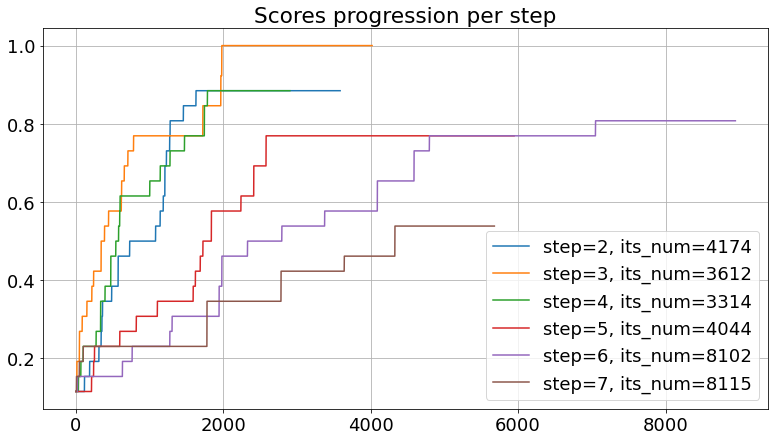

In [39]:
plt.figure(figsize=(13, 7))

for step, scores, it_num in plot_info:
    plt.plot(scores, label=f'step={step}, its_num={it_num}')
#     plt.axvline(it_num, c='k', linestyle='--', alpha=0.8)

plt.title('Scores progression per step')
# plt.xlabel('x')

plt.legend()
plt.grid()
plt.show()